In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

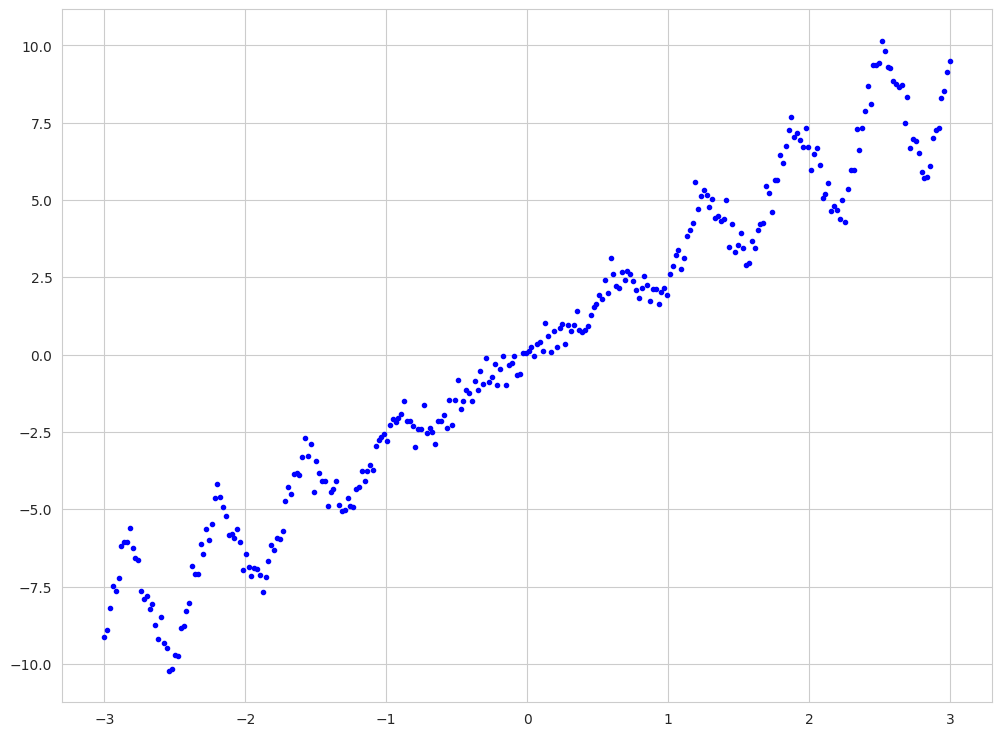

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

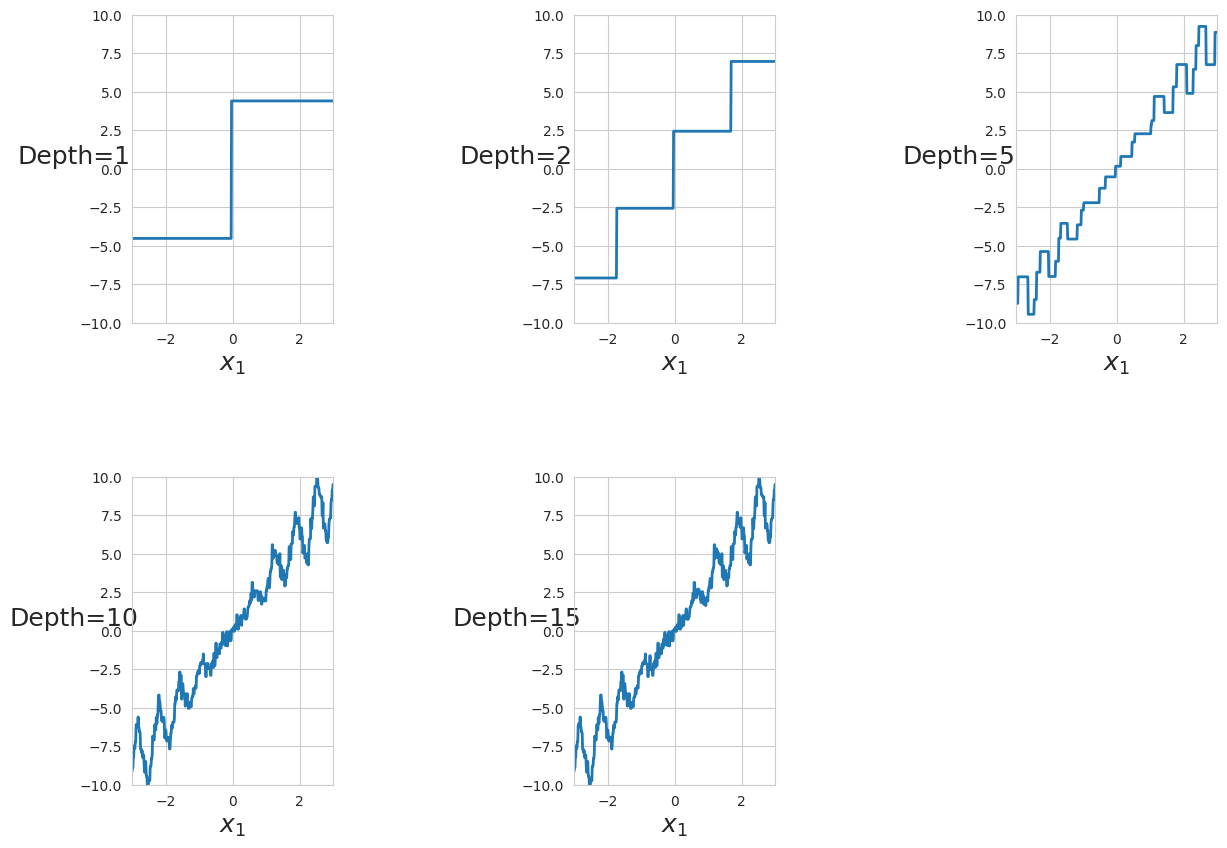

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
max_depths = [1, 2, 5, 10, 15]
plt.figure(figsize=(14, 10))

for i, max_depth in enumerate(max_depths, 1):
    plt.subplot(2, 3, i)
    tree_reg = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree_reg.fit(X, y)
    plot_regression_predictions(tree_reg, X, y, ylabel=f"Depth={max_depth}")

plt.subplots_adjust(wspace=1.2, hspace=0.5)

plt.show()

С возрастанием глубины дерева предсказания становятся более точными. Разница между глубинами 10 и 15 визуально отсутвует.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

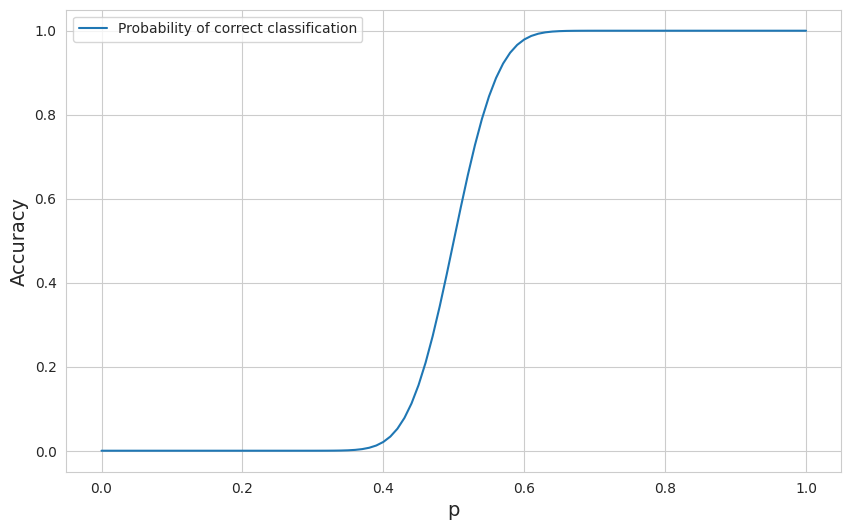

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
from scipy.special import comb

def compute_accuracy(p):
    accuracy = 0
    for i in range(51, 102):
        accuracy += comb(101, i) * (p ** i) * ((1 - p) ** (101 - i))
    return accuracy

p_values = np.linspace(0, 1, 101)
accuracies = [compute_accuracy(p) for p in p_values]

plt.figure(figsize=(10, 6))
plt.plot(p_values, accuracies, label='Probability of correct classification')
plt.xlabel('p', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.show()

Зависимость имеет S-образное распределение с экспоненциальной фазой после достижения вероятности равной 0.4. При достижении вероятности равной примерно 0.6 наблюдается выход на плато, где точность равна 100%.

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

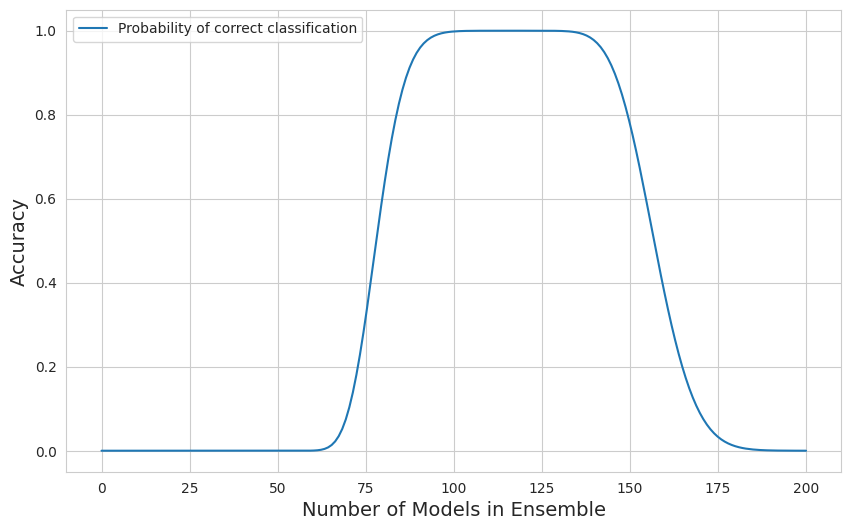

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

def compute_fixed_accuracy(m):
    accuracy = 0
    for i in range(51, 102):
        accuracy += comb(m, i) * (0.65 ** i) * ((1 - 0.65) ** (m - i))
    return accuracy

m_quantity = np.linspace(0, 200, 200)
accuracies_fixed = [compute_fixed_accuracy(int(m)) for m in m_quantity]
5
plt.figure(figsize=(10, 6))
plt.plot(m_quantity, accuracies_fixed, label='Probability of correct classification')
plt.xlabel('Number of Models in Ensemble', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

При наличии фиксированного значения вероятности и изменении числа моделей в ансамбле максимум наблюдается при значениях находящихся между ~90-135. Далее и перед ними зоны экспоненциального роста точности, а после 0.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [8]:
class RandomForestClassifierCustom:
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=None
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = np.unique(y)

        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)

            feat_ids = np.random.choice(range(X.shape[1]), self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)

            indices = np.random.choice(range(X.shape[0]), X.shape[0], replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]

            tree = DecisionTreeClassifier(
                max_depth=self.max_depth, random_state=self.random_state
            )
            tree.fit(X_bootstrap[:, feat_ids], y_bootstrap)
            self.trees.append(tree)

        return self

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], len(self.classes_)))

        for i, tree in enumerate(self.trees):
            feat_ids = self.feat_ids_by_tree[i]
            probas += tree.predict_proba(X[:, feat_ids])

        probas /= len(self.trees)

        return probas

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)

        return predictions


Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [9]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

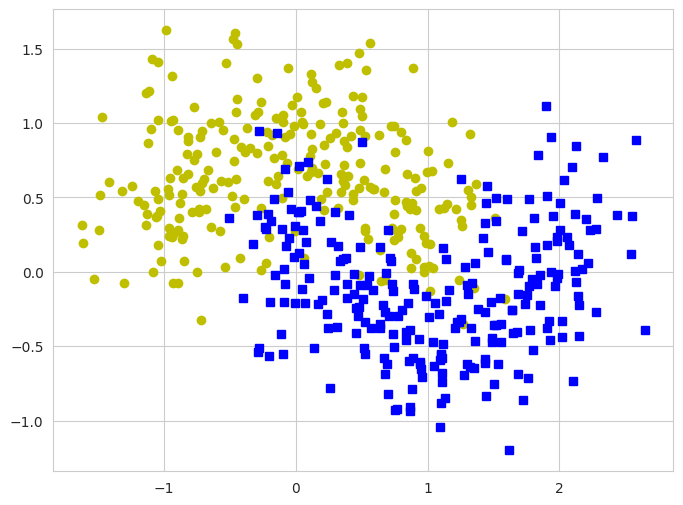

In [10]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

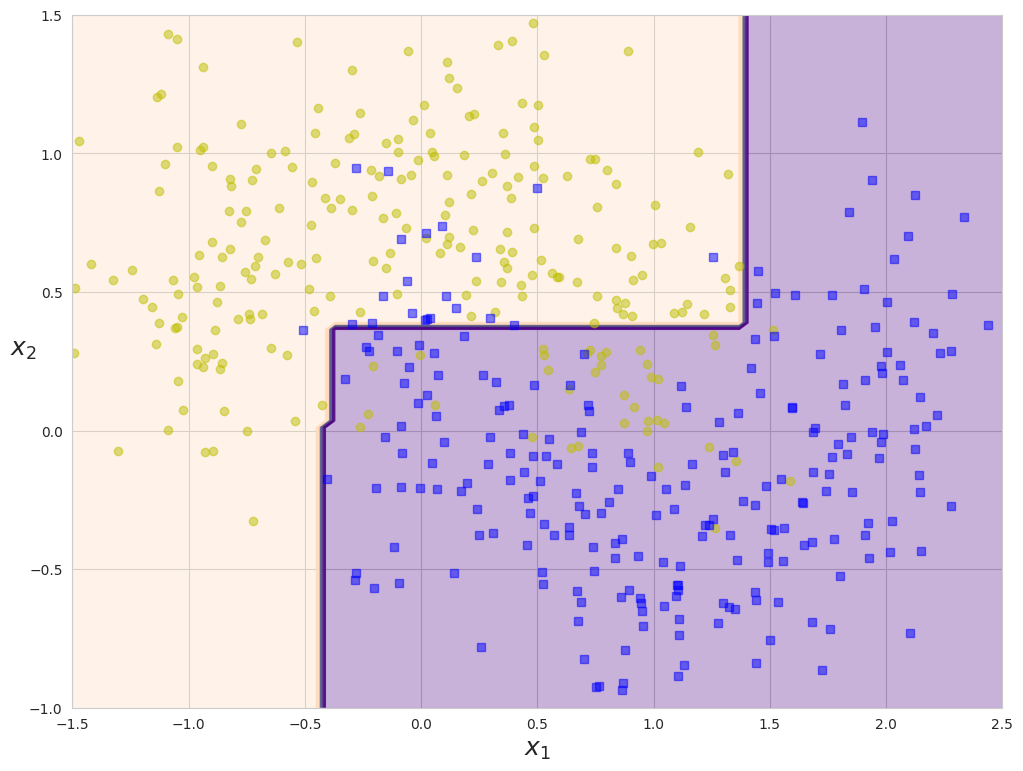

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
rf = RandomForestClassifierCustom(n_estimators=10, max_depth=3, max_features=2, random_state=SEED)
rf.fit(X_train, y_train)
plot_decision_boundary(rf, X, y)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [12]:
from sklearn.metrics import mean_squared_error

def bootstrap_metric(x,
                     y,
                     metric_fn,
                     samples_cnt=1000,
                     alpha=0.05,
                     random_state=42):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], 
                                 replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val
    
    return b_metric

def train_and_test_regressor(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Fitting {name}")
        model.fit(X_train, y_train)
    predictions = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        
    boot_scores = {}

    for name, y_pred in predictions.items():
        print(f"Calculating bootstrap score for {name}")
        boot_score = bootstrap_metric(y_test, 
                                      y_pred, 
                                      metric_fn=lambda x, y: mean_squared_error(y_true=x, 
                                                                                y_pred=y))
        boot_scores[name] = boot_score
        
    
    results = pd.DataFrame(boot_scores)
    
    results = results.melt(value_vars=results.columns,
                           value_name="mse", 
                           var_name="model")
    return results

In [13]:
models_list = {}

for depth in [1, 3, 5, 7, None]:
    for n in [3, 10, 100]:
        models_list[f"RF_depth{depth}_n_estimators{n}"] = RandomForestClassifierCustom(
            n_estimators=n,
            max_depth=depth,
            max_features=2,
            random_state=SEED
        )
    
results_depth = train_and_test_regressor(models_list, X_train, y_train, X_test, y_test)


Fitting RF_depth1_n_estimators3
Fitting RF_depth1_n_estimators10
Fitting RF_depth1_n_estimators100
Fitting RF_depth3_n_estimators3
Fitting RF_depth3_n_estimators10
Fitting RF_depth3_n_estimators100
Fitting RF_depth5_n_estimators3
Fitting RF_depth5_n_estimators10
Fitting RF_depth5_n_estimators100
Fitting RF_depth7_n_estimators3
Fitting RF_depth7_n_estimators10
Fitting RF_depth7_n_estimators100
Fitting RF_depthNone_n_estimators3
Fitting RF_depthNone_n_estimators10
Fitting RF_depthNone_n_estimators100
Calculating bootstrap score for RF_depth1_n_estimators3
Calculating bootstrap score for RF_depth1_n_estimators10
Calculating bootstrap score for RF_depth1_n_estimators100
Calculating bootstrap score for RF_depth3_n_estimators3
Calculating bootstrap score for RF_depth3_n_estimators10
Calculating bootstrap score for RF_depth3_n_estimators100
Calculating bootstrap score for RF_depth5_n_estimators3
Calculating bootstrap score for RF_depth5_n_estimators10
Calculating bootstrap score for RF_depth5

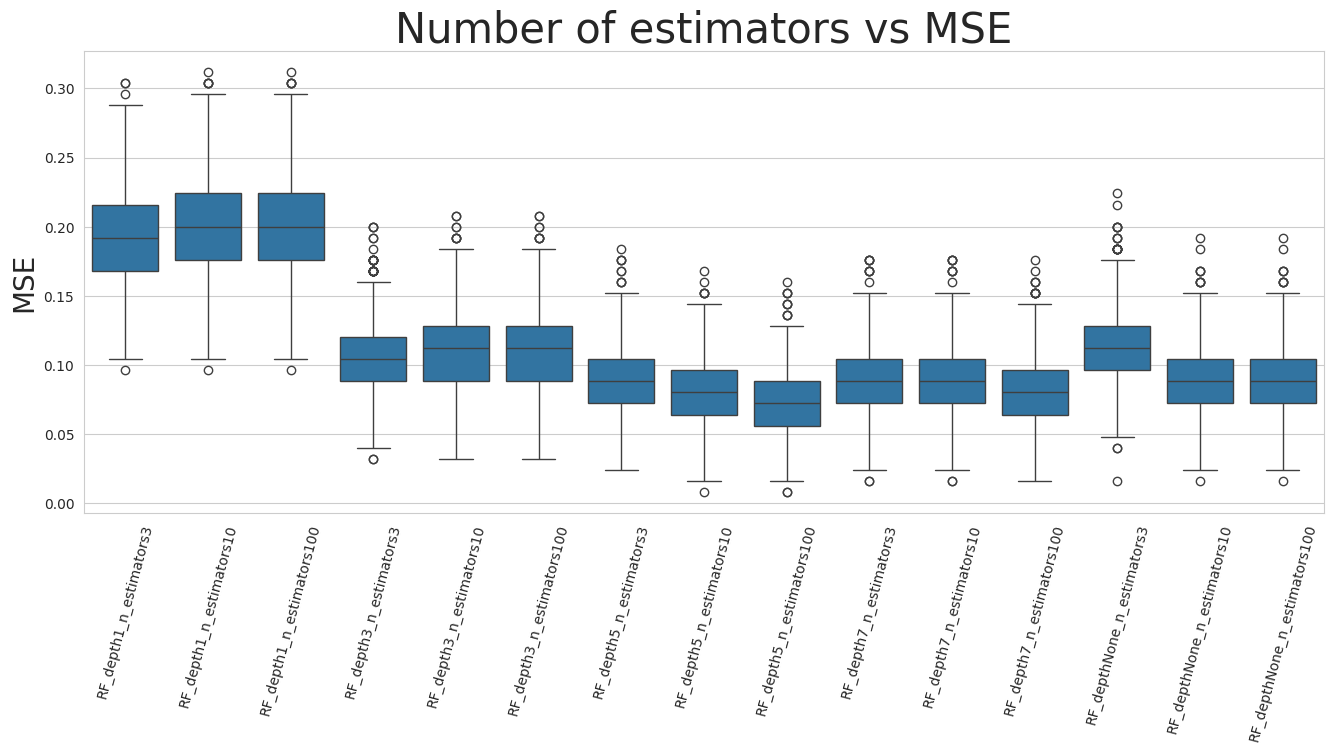

In [14]:
plt.figure(figsize=(16,6))
sns.boxplot(data=results_depth, y="mse", x="model")
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Number of estimators vs MSE", size=30)
plt.xticks(rotation=75)
plt.show()

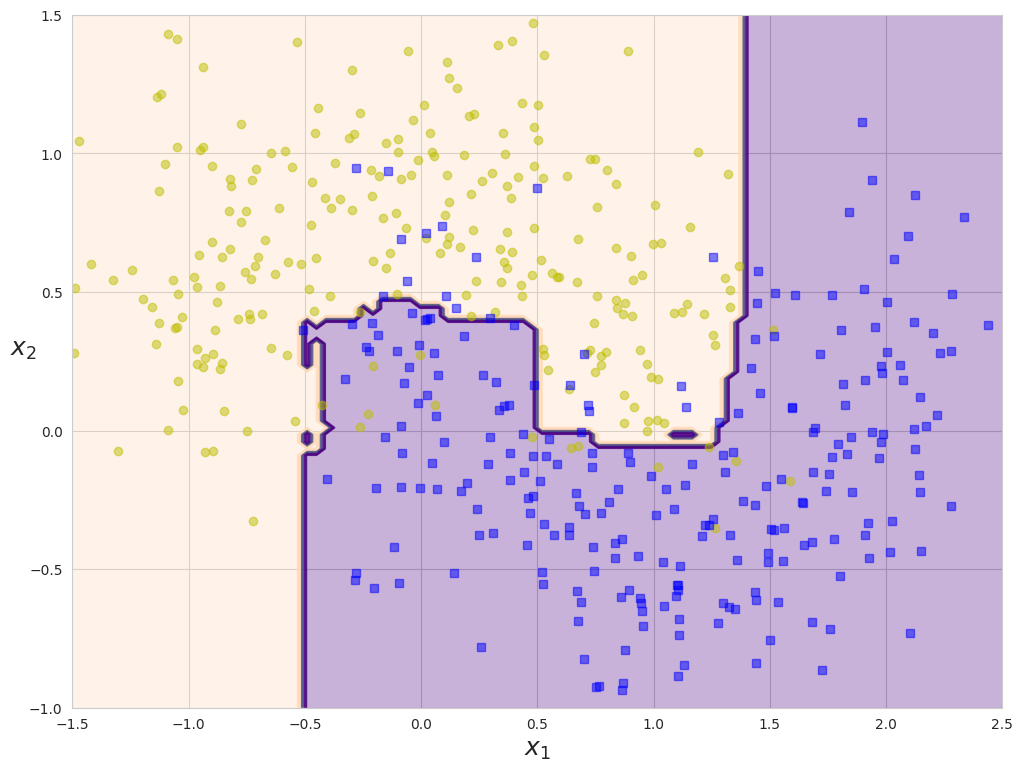

In [15]:
# Гиперпараметры лучшей модели
rf = RandomForestClassifierCustom(n_estimators=100, max_depth=5, max_features=2, random_state=SEED)
rf.fit(X_train, y_train)
plot_decision_boundary(rf, X, y)

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [16]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [17]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

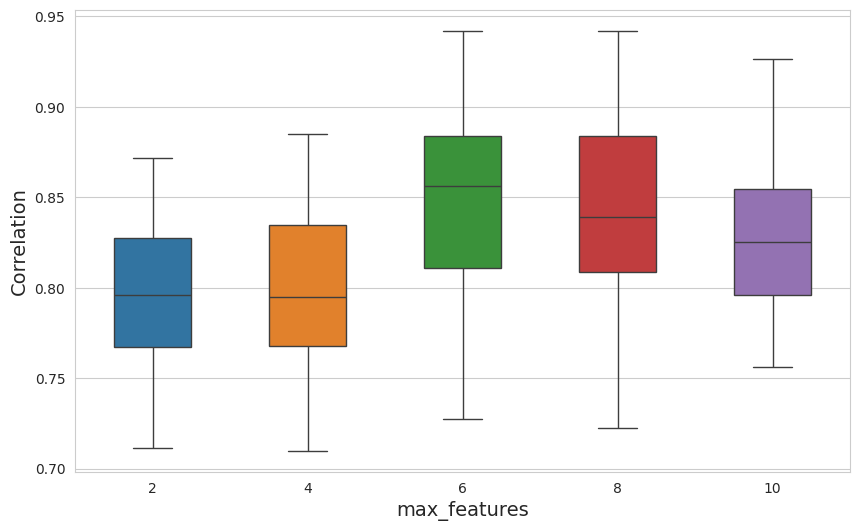

In [18]:
max_features_list = [2, 4, 6, 8, 10]
correlation_results = {}

for max_features in max_features_list:
    rf = RandomForestClassifier(n_estimators=10, max_features=max_features, random_state=42)
    rf.fit(X_train, y_train)
    corrs = base_model_pair_correlation(rf, X_test)
    correlation_results[max_features] = corrs

plt.figure(figsize=(10, 6))
sns.boxplot(data=list(correlation_results.values()), width=0.5)
plt.xticks(ticks=range(len(max_features_list)), labels=max_features_list)
plt.xlabel('max_features', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

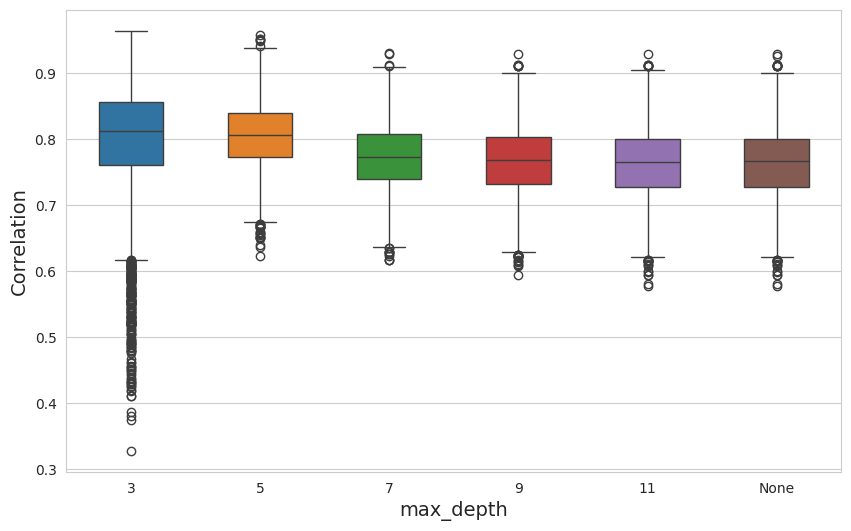

In [19]:
max_depth_list = [3, 5, 7, 9, 11, None]
correlation_results = {}

for max_depth in max_depth_list:
    rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, max_features=2, random_state=42)
    rf.fit(X_train, y_train)
    corrs = base_model_pair_correlation(rf, X_test)
    correlation_results[max_depth] = corrs

plt.figure(figsize=(10, 6))
sns.boxplot(data=list(correlation_results.values()), width=0.5)
plt.xticks(ticks=range(len(max_depth_list)), labels=[str(md) for md in max_depth_list])
plt.xlabel('max_depth', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.show()

Опишите ваши наблюдения:

* Величина параметра **max_fatures** не оказывает влияние на корреляцию между моделями.
* При возрастании глубины дерева показатель корреляции снижается до уровня 9, после чего снижение идет уже менее интенсивно. Это влияет на bagging положительно.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [20]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O data/heart.csv -q
heart_dataset = pd.read_csv("data/heart.csv")

/bin/bash: line 1: gdown: command not found


In [21]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [22]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [23]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')



for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [24]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [25]:
classifiers = [dt, rf, etc, knn, svc_lin, svc_rbf, cat, lgbm, lgbm_rf, xgb, xgb_rf, lr, nb, voting_hard, voting_soft]

for clf in classifiers:
    clf.fit(X_train, y_train)

correlations_hard = base_model_pair_correlation_for_voting_clf(voting_hard, X_test)
correlations_soft = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [26]:
from catboost import CatBoostClassifier

In [27]:
data = pd.read_csv("data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [28]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())
    print("\nDatatypes of the variables:")
    print(df.dtypes)

dataoveriew(data, 'Overiew of the training dataset')

Overiew of the training dataset:

Rows: 3333

Number of features: 21

Features:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Missing values: 0

Unique values:
State               51
Account Length     212
Area Code            3
Phone             3333
Int'l Plan           2
VMail Plan           2
VMail Message       46
Day Mins          1667
Day Calls          119
Day Charge        1667
Eve Mins          1611
Eve Calls          123
Eve Charge        1440
Night Mins        1591
Night Calls        120
Night Charge       933
Intl Mins          162
Intl Calls          21
Intl Charge        162
CustServ Calls      10
Churn?               2
dtype: int64

Datatypes of the variables:
State              object
Account Length      int64
Area Code           

In [29]:
enc = OrdinalEncoder()

categorical_cols = ['State', 'Phone', "Int'l Plan", "VMail Plan", "Churn?"]
encoded_data = enc.fit_transform(data[categorical_cols])
data[categorical_cols] = encoded_data

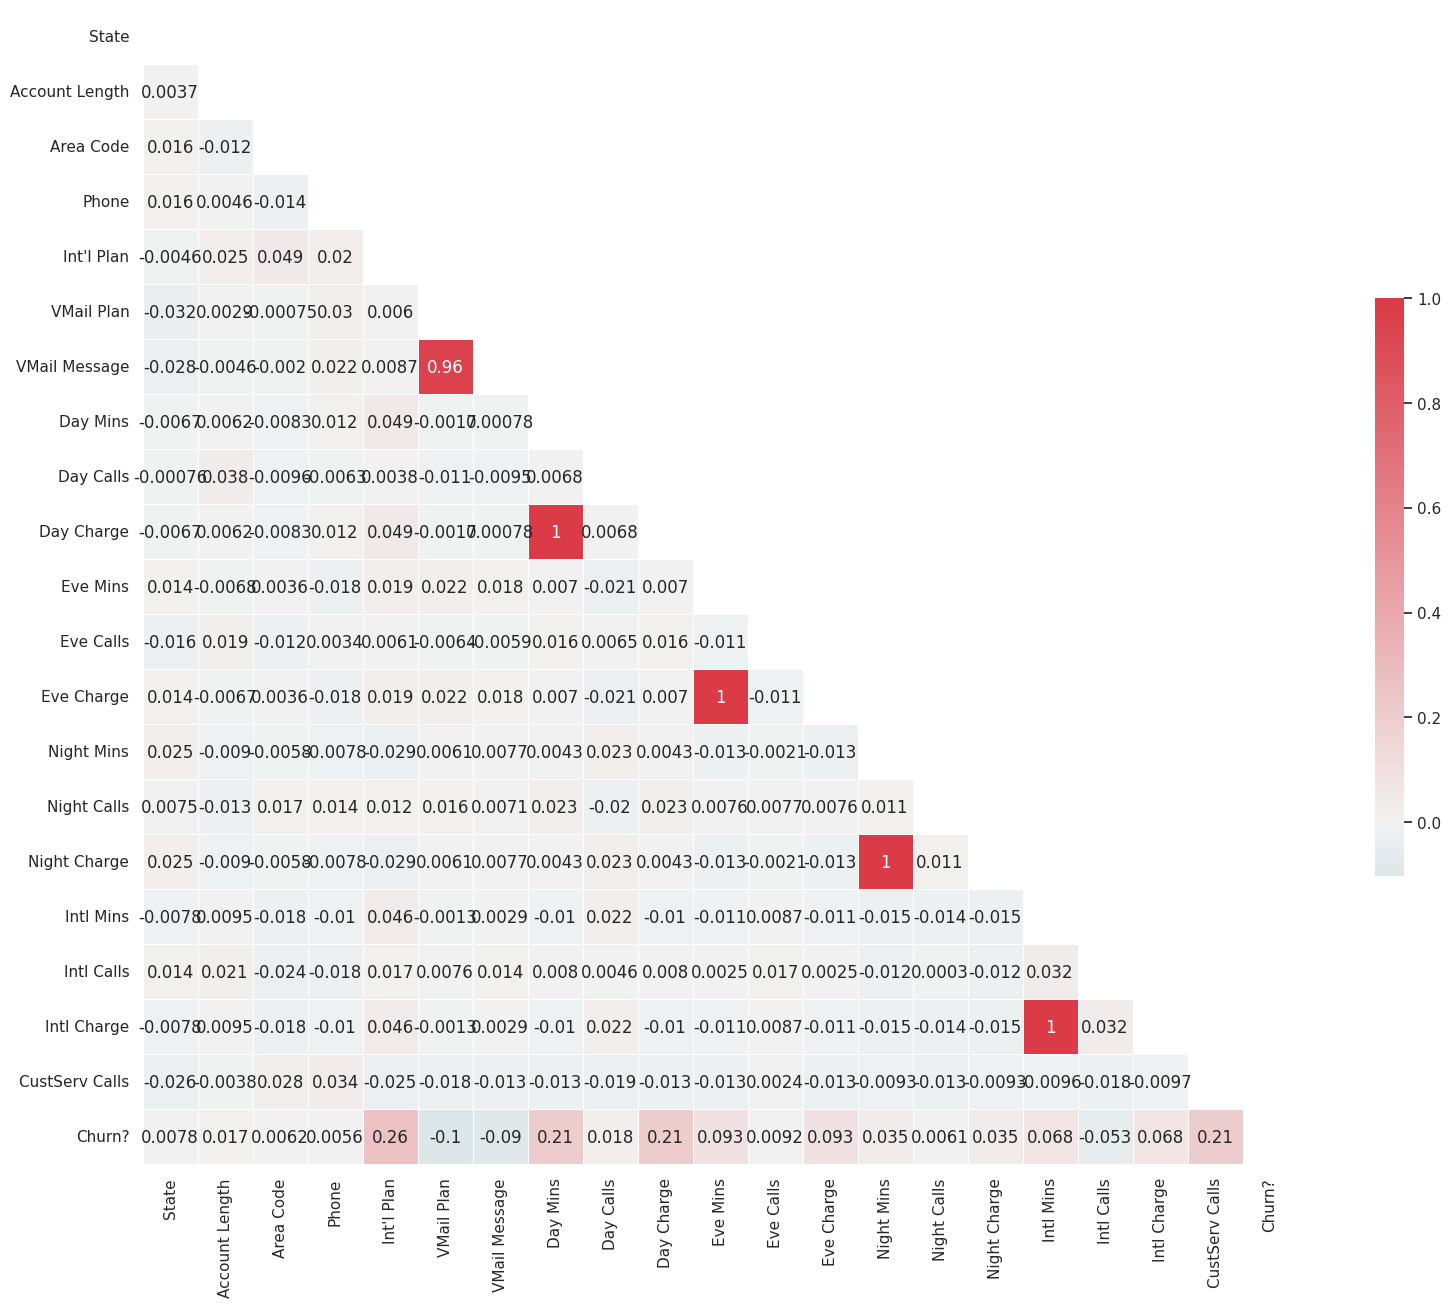

In [30]:
sns.set(style="white")

mask = np.zeros_like(data.corr(), dtype= bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(data.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();


In [31]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
State,3333.0,26.059406,14.824911,0.00,14.00,26.00,39.00,50.00
Account Length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00
Area Code,3333.0,437.182418,42.371290,408.00,408.00,415.00,510.00,510.00
Phone,3333.0,1666.000000,962.298550,0.00,833.00,1666.00,2499.00,3332.00
Int'l Plan,3333.0,0.096910,0.295879,0.00,0.00,0.00,0.00,1.00
VMail Plan,3333.0,0.276628,0.447398,0.00,0.00,0.00,1.00,1.00
VMail Message,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00
Day Mins,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80
Day Calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00
Day Charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64


In [32]:
from sklearn.preprocessing import MinMaxScaler


norm_t = MinMaxScaler().fit(data)

normal_numeric_data_t = norm_t.transform(data)
cols_t = data.columns.values

normal_numeric_data_t = pd.DataFrame(data = normal_numeric_data_t, columns = cols_t)
normal_numeric_data_t.head(5)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,0.32,0.524793,0.068627,0.578031,0.0,1.0,0.490196,0.755701,0.666667,0.755701,...,0.582353,0.542866,0.595750,0.408451,0.595935,0.500,0.15,0.500000,0.111111,0.0
1,0.70,0.438017,0.068627,0.472689,0.0,1.0,0.509804,0.460661,0.745455,0.460597,...,0.605882,0.537690,0.621840,0.492958,0.622236,0.685,0.15,0.685185,0.111111,0.0
2,0.62,0.561983,0.068627,0.335234,0.0,0.0,0.000000,0.693843,0.690909,0.693830,...,0.647059,0.333225,0.374933,0.500000,0.375374,0.610,0.25,0.609259,0.000000,0.0
3,0.70,0.342975,0.000000,0.512305,1.0,0.0,0.000000,0.853478,0.430303,0.853454,...,0.517647,0.170171,0.467187,0.394366,0.467424,0.330,0.35,0.329630,0.222222,0.0
4,0.72,0.305785,0.068627,0.033013,1.0,0.0,0.000000,0.475200,0.684848,0.475184,...,0.717647,0.407959,0.440290,0.619718,0.440526,0.505,0.15,0.505556,0.333333,0.0


In [33]:
from catboost import CatBoostClassifier, Pool
import optuna
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score 

def objective(trial: optuna.Trial) -> float:

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "Accuracy",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = CatBoostClassifier(**param)

    pruning_callback = optuna.integration.CatBoostPruningCallback(trial, "Accuracy")
    gbm.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    pruning_callback.check_pruned()

    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)

    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Accuracy:", study.best_trial.values, "Best params:", best_params)


[I 2024-03-12 15:46:11,663] A new study created in memory with name: no-name-6c66de42-b770-4831-97bd-fc1d8dc2c418
[I 2024-03-12 15:46:11,741] Trial 0 finished with value: 0.8421052631578947 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.062056311743996305, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.040857770078466}. Best is trial 0 with value: 0.8421052631578947.
[I 2024-03-12 15:46:11,916] Trial 1 finished with value: 0.7894736842105263 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.010286846585565706, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.089215133074092}. Best is trial 0 with value: 0.8421052631578947.
[I 2024-03-12 15:46:12,051] Trial 2 finished with value: 0.868421052631579 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09744184698874973, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with 

Accuracy: [0.881578947368421] Best params: {'objective': 'Logloss', 'colsample_bylevel': 0.08800488983158983, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}


In [34]:
import lightgbm as lgb


def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),  
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.1),  
        "max_depth": trial.suggest_int("max_depth", 2, 10),  
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),  
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [35]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
print("Best RMSE:", study.best_trial.values, "Best params:", best_params)

[I 2024-03-12 15:46:15,635] A new study created in memory with name: no-name-0b255827-8b4a-4d3e-92de-33e43e2b0585
[I 2024-03-12 15:46:15,704] Trial 0 finished with value: 0.45883146774112354 and parameters: {'n_estimators': 754, 'learning_rate': 0.05359180366749508, 'max_depth': 8, 'num_leaves': 124}. Best is trial 0 with value: 0.45883146774112354.
[I 2024-03-12 15:46:15,741] Trial 1 finished with value: 0.42919753763947605 and parameters: {'n_estimators': 390, 'learning_rate': 0.06412192532180883, 'max_depth': 7, 'num_leaves': 282}. Best is trial 1 with value: 0.42919753763947605.
[I 2024-03-12 15:46:15,759] Trial 2 finished with value: 0.4442616583193193 and parameters: {'n_estimators': 168, 'learning_rate': 0.08328496298108326, 'max_depth': 5, 'num_leaves': 477}. Best is trial 1 with value: 0.42919753763947605.
[I 2024-03-12 15:46:15,786] Trial 3 finished with value: 0.4442616583193193 and parameters: {'n_estimators': 284, 'learning_rate': 0.06020466069627169, 'max_depth': 5, 'num_

Best RMSE: [0.42919753763947605] Best params: {'n_estimators': 390, 'learning_rate': 0.06412192532180883, 'max_depth': 7, 'num_leaves': 282}


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [36]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**